cuda:0


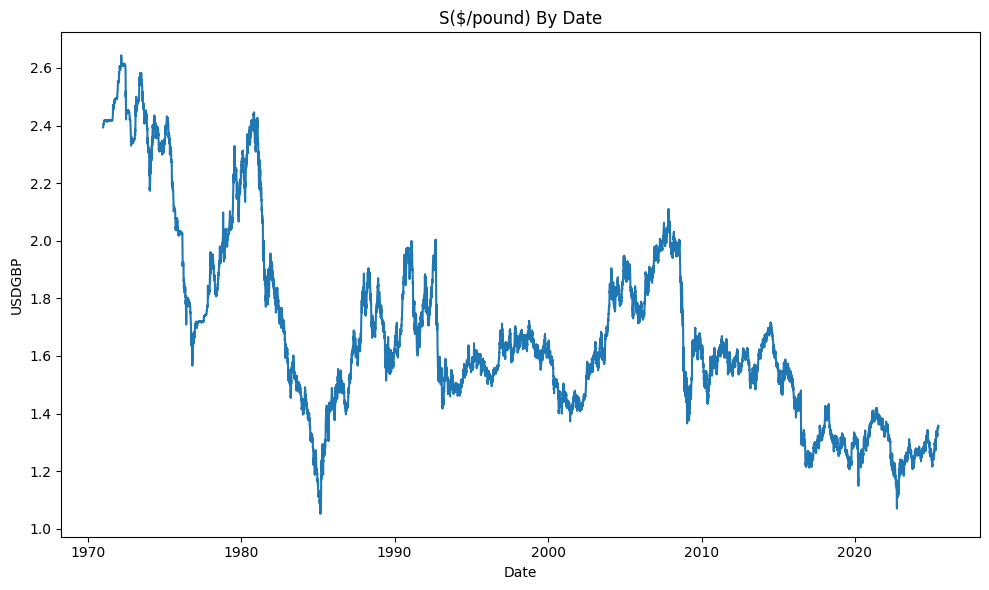

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler



device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






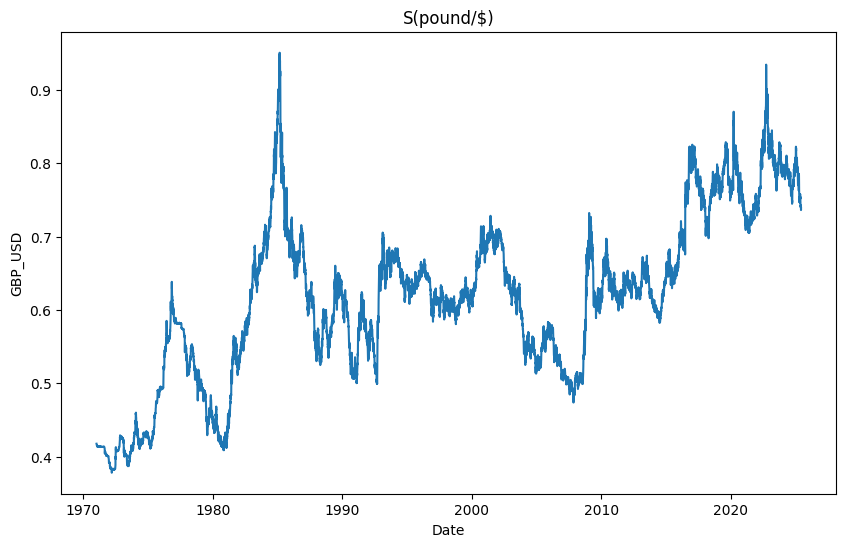

In [2]:
""" Example of S(pound/USD)"""

df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:

""" there is no Arbitrage in the FX market
 1 / USDGBP == GBPUSD; 1 / GBPUSD == USDGBP"""

GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.357      0.73691968]
  [0.73691968 1.357     ]]

 [[1.3584     0.73616019]
  [0.73616019 1.3584    ]]

 [[1.3532     0.73898906]
  [0.73898906 1.3532    ]]]


In [4]:


df_train = df.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length - 1):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
model

LSTM(
  (lstm): LSTM(1, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [5]:
model = LSTM(input_size=1,hidden_size=228,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
loss_fn = nn.MSELoss()
epochs = 200


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_17168\2667991879.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_17168\2667991879.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.1813; Test RSME: 0.2762
Epoch: 1; train_RSEM: 0.1599; Test RSME: 0.2728
Epoch: 2; train_RSEM: 0.3722; Test RSME: 0.08496
Epoch: 3; train_RSEM: 0.2345; Test RSME: 0.06599
Epoch: 4; train_RSEM: 0.1609; Test RSME: 0.2775
Epoch: 5; train_RSEM: 0.1783; Test RSME: 0.3006
Epoch: 6; train_RSEM: 0.1527; Test RSME: 0.1604
Epoch: 7; train_RSEM: 0.1882; Test RSME: 0.1047
Epoch: 8; train_RSEM: 0.1634; Test RSME: 0.1206
Epoch: 9; train_RSEM: 0.1195; Test RSME: 0.1935
Epoch: 10; train_RSEM: 0.1696; Test RSME: 0.2704
Epoch: 11; train_RSEM: 0.1166; Test RSME: 0.2064
Epoch: 12; train_RSEM: 0.1139; Test RSME: 0.1262
Epoch: 13; train_RSEM: 0.1343; Test RSME: 0.08851
Epoch: 14; train_RSEM: 0.112; Test RSME: 0.09271
Epoch: 15; train_RSEM: 0.0702; Test RSME: 0.1298
Epoch: 16; train_RSEM: 0.1122; Test RSME: 0.1659
Epoch: 17; train_RSEM: 0.06222; Test RSME: 0.1194
Epoch: 18; train_RSEM: 0.06408; Test RSME: 0.05468
Epoch: 19; train_RSEM: 0.08694; Test RSME: 0.0271
Epoch: 20; train_RSEM: 

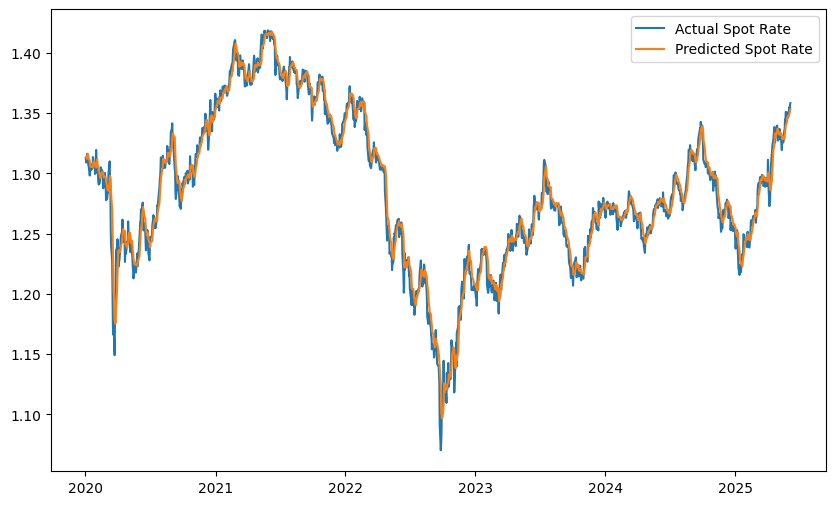

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:-1]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()


In [8]:
print(np.round(comparison_df,4).head(20))
print(np.round(comparison_df,4).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12292 2020-01-02            1.3128               1.3135
12293 2020-01-03            1.3091               1.3140
12294 2020-01-06            1.3163               1.3121
12295 2020-01-07            1.3127               1.3155
12296 2020-01-08            1.3110               1.3161
12297 2020-01-09            1.3069               1.3138
12298 2020-01-10            1.3060               1.3126
12299 2020-01-13            1.2983               1.3105
12300 2020-01-14            1.3018               1.3070
12301 2020-01-15            1.3030               1.3056
12302 2020-01-16            1.3076               1.3055
12303 2020-01-17            1.3029               1.3060
12304 2020-01-21            1.3047               1.3052
12305 2020-01-22            1.3136               1.3050
12306 2020-01-23            1.3104               1.3084
12307 2020-01-24            1.3071               1.3099
12308 2020-01-27            1.3054              